In [50]:
%matplotlib inline
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from deap import base, creator, tools, gp
import operator
import itertools

In [51]:
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')

In [52]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [53]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [54]:
random.seed(100)
np.random.seed(100)

train_data.drop(columns=['Name', 'Ticket', 'Cabin'], inplace=True)
train_data.set_index(keys=['PassengerId'], drop=True, inplace=True)

test_data.drop(columns=['Name', 'Ticket', 'Cabin'], inplace=True)
test_data.set_index(keys=['PassengerId'], drop=True, inplace=True)

train_nan_map = {'Age': train_data['Age'].mean(), 'Fare': train_data['Fare'].mean(), 'Embarked': train_data['Embarked'].mode()[0]}
test_nan_map = {'Age': test_data['Age'].mean(), 'Fare': test_data['Fare'].mean(), 'Embarked': test_data['Embarked'].mode()[0]}

train_data.fillna(value=train_nan_map, inplace=True)
test_data.fillna(value=test_nan_map, inplace=True)

columns_map = {'Embarked': {'C': 0, 'Q': 1, 'S': 2}, 'Sex': {'male': 0, 'female': 1}}
train_data.replace(columns_map, inplace=True)
test_data.replace(columns_map, inplace=True)

X_train = train_data.loc[:, train_data.columns != 'Survived']
y_train = train_data.loc[:, 'Survived']
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=10)
X_train = X_train.astype(float)
test_data = test_data.astype(float)
X_train = X_train.to_numpy()
test_data = test_data.to_numpy()
print(X_train)
print(test_data)


[[  2.           0.          48.         ...   0.          13.
    2.        ]
 [  3.           0.          29.69911765 ...   2.          69.55
    2.        ]
 [  3.           1.          29.69911765 ...   0.           7.75
    1.        ]
 ...
 [  1.           0.          29.69911765 ...   0.         221.7792
    2.        ]
 [  3.           0.          12.         ...   0.          11.2417
    0.        ]
 [  2.           0.          36.         ...   0.          10.5
    2.        ]]
[[ 3.          0.         34.5        ...  0.          7.8292
   1.        ]
 [ 3.          1.         47.         ...  0.          7.
   2.        ]
 [ 2.          0.         62.         ...  0.          9.6875
   1.        ]
 ...
 [ 3.          0.         38.5        ...  0.          7.25
   2.        ]
 [ 3.          0.         30.27259036 ...  0.          8.05
   2.        ]
 [ 3.          0.         30.27259036 ...  1.         22.3583
   0.        ]]


In [55]:
creator.create("FitnessMin",base.Fitness,weights=(-1.0,-1.0))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)
#
pset = gp.PrimitiveSetTyped("MAIN", [float,float,float,float,float,float,float],bool)
#How do I define outtype of tree?
pset.renameArguments(ARG0='Pclass',ARG1='Sex',ARG2='Age',ARG3='SibSp',ARG4='Parch',ARG5='Fare',ARG6='Embarked')
# Boolean Operators
pset.addPrimitive(operator.and_, [bool, bool], bool)
pset.addPrimitive(operator.or_, [bool, bool], bool)
pset.addPrimitive(operator.not_, [bool], bool)
def specialDivision(first,last):
    try:
        return first/last

    except ZeroDivisionError:
        return 1
#Float Operators
pset.addPrimitive(operator.add, [float,float], float)
pset.addPrimitive(operator.sub, [float,float], float)
pset.addPrimitive(operator.mul, [float,float], float)
pset.addPrimitive(specialDivision, [float,float], float)
#Add Comparision Operators
pset.addPrimitive(operator.lt, [float, float], bool)
pset.addPrimitive(operator.eq, [float, float], bool)
pset.addPrimitive(operator.gt, [float,float],bool)

#Conditional Operator
def if_then_else(first,middle,last):
    if first:
        return middle
    else:
        return last
pset.addPrimitive(if_then_else,[bool,float,float],float)


pset.addPrimitive(if_then_else, [bool, float, float], float)

pset.addTerminal(True,bool)
pset.addTerminal(False,bool)






C:\Users\ankit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\ankit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [56]:
toolbox = base.Toolbox()

toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("compile", gp.compile, pset=pset)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("select", tools.selNSGA2,nd='standard')
def evalInd(individual,pset):
    func  = gp.compile(expr=individual,pset=pset)
    # Need to find a way to return the
    
    y_train_bool=[]
    for row in X_train:
        row = row.tolist()
        y_train_bool.append(func(*row))
    y_train_pred=[]
    for element in y_train_bool:
        
        if element:
            y_train_pred.append(1)
        else:
            y_train_pred.append(0)
    
    confusion = confusion_matrix(y_train,y_train_pred)

    FNR = confusion[1][0] / (confusion[1][0] + confusion[1][1])
    FPR = confusion[0][1] / (confusion[0][0] + confusion[0][1])
    return (FNR,FPR)
toolbox.register("evaluate",evalInd,pset=pset)

pop = toolbox.population(n=500)

cxpb = .7
mutpb = .2
ngen = 50

fitnesses =  list(map(toolbox.evaluate,pop))
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

for g in range(ngen):
    print("-- Generation %i --" % g)
    offspring = toolbox.select(pop, len(pop))

    offspring = list(map(toolbox.clone, offspring))

    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < cxpb:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < mutpb:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    pop[:] = offspring

    fit0  = [ind.fitness.values[0] for ind in pop]
    fit1 = [ind.fitness.values[1] for ind in pop]
    length = len(pop)
    mean0 = sum(fit0) / length
    sum20 = sum(x*x for x in fit0)
    std0 = abs(sum20 / length - mean0**2)**0.5
    mean1 = sum(fit1) / length
    sum21 = sum(x*x for x in fit1)
    std1 = abs(sum21 / length - mean1**2)**0.5
    print("Mean:",(mean0,mean1))
    print("Std Deviation:",(std0,std1))

best_ind = tools.selBest(pop, 1)[0]

print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))

-- Generation 0 --
Mean: (0.5783361344537812, 0.4299888268156423)
Std Deviation: (0.45465185101144556, 0.4665662108294286)
-- Generation 1 --
Mean: (0.5769495798319326, 0.4284301675977657)
Std Deviation: (0.4580147125843433, 0.47118862370593123)
-- Generation 2 --
Mean: (0.5461008403361343, 0.4548826815642461)
Std Deviation: (0.45852637621074216, 0.46958722649874424)
-- Generation 3 --
Mean: (0.5403277310924369, 0.4695251396648051)
Std Deviation: (0.4539311999458753, 0.4667171137171274)
-- Generation 4 --
Mean: (0.5621176470588234, 0.44384357541899455)
Std Deviation: (0.449403431661932, 0.46294971635579496)
-- Generation 5 --
Mean: (0.5590420168067224, 0.437486033519553)
Std Deviation: (0.45099207420887527, 0.4639921894941903)
-- Generation 6 --
Mean: (0.5334285714285715, 0.46254189944134094)
Std Deviation: (0.44770917786477654, 0.46374602422909816)
-- Generation 7 --
Mean: (0.5237563025210082, 0.4815307262569831)
Std Deviation: (0.4470915647169093, 0.4627139401196748)
-- Generation 8 

In [57]:
individual_fitnesses = [ind.fitness.values for ind in pop]


In [58]:
def paretoDominance(ind1,ind2):
    if ((ind1[0] < ind2[0]) and (ind1[1] < ind2[1])):
        return 1
    if ((ind2[0] < ind1[0]) and (ind2[1] < ind1[1])):
        return -1
    return 0

290
210
Area Under Curve: 0.18935730716867755


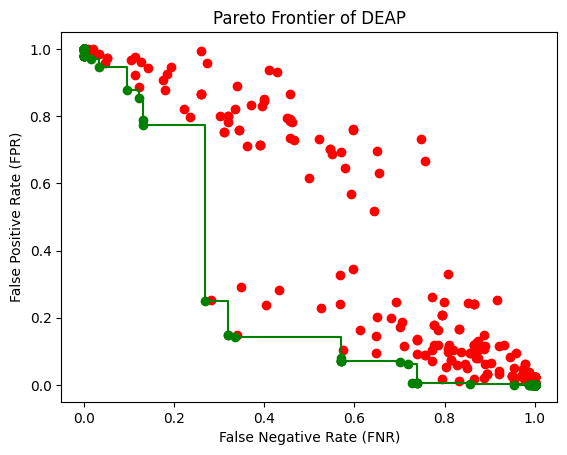

In [59]:

pareto_frontier=[]
non_frontier=[]
for model1 in individual_fitnesses:
    pareto = True
    for model2 in individual_fitnesses:
        if (paretoDominance(model1,model2) == -1):
            pareto = False
    if pareto:
        pareto_frontier.append(model1)
    else:
        non_frontier.append(model1)

pareto_frontier.sort(key=lambda x: x[1])
pareto_frontier_x = [model[0] for model in pareto_frontier]
pareto_frontier_y = [model[1] for model in pareto_frontier]
non_frontier_x = [model[0] for model in non_frontier]
non_frontier_y = [model[1] for model in non_frontier]
print(len(pareto_frontier))
print(len(non_frontier))
plt.scatter(non_frontier_x,non_frontier_y,color="r")
plt.scatter(pareto_frontier_x,pareto_frontier_y,color="g")
plt.plot(pareto_frontier_x,pareto_frontier_y, color="g",drawstyle='steps') #Doesn't draw Steps post when I set drawstyle to 'steps-post'?
plt.xlabel("False Negative Rate (FNR)")
plt.ylabel("False Positive Rate (FPR)")
plt.title("Pareto Frontier of DEAP")


f1 = np.array(pareto_frontier_x)
f2 = np.array(pareto_frontier_y)

"""Calculate area under curve with least squares method"""
print("Area Under Curve: %s" % (np.sum(np.abs(np.diff(f1))*f2[:-1])))